## Image classification with Convolutional Neural Networks

CNN to solve Dogs vs Cats Kaggle competition
The dataset is available at http://files.fast.ai/data/dogscats.zip.
You should put the data in a subdirectory of this notebook's directory, called data/

In [1]:
# Notebook's automatic reloading(imports) and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# main external libs
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
# Nvidia Cuda Framework support
torch.cuda.is_available()

True

In [4]:
# Nvidia CuDNN support
torch.backends.cudnn.enabled

True

In [5]:
# `sz` is the size that the images will be resized to.(trains quickly)
PATH = "data/dogscats/"
sz = 224

In [6]:
# List directory 'dogscats' contents
os.listdir(PATH)

['models', 'sample', 'test1', 'train', 'valid']

In [7]:
# List directory 'dogscats/valid' contents
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [8]:
# List directory 'dogscats/valid/cats' contents(five rows/five files)
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.1001.jpg',
 'cat.10016.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg']

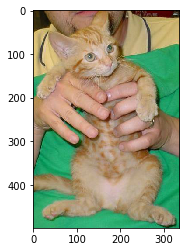

In [9]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)

In [10]:
# (M, N, 3)
img.shape

(499, 336, 3)

In [21]:
img[:4, :4]

array([[[60, 58, 10],
        [60, 57, 14],
        [61, 56, 18],
        [63, 54, 23]],

       [[56, 54,  6],
        [56, 53, 10],
        [57, 52, 14],
        [60, 51, 20]],

       [[52, 49,  4],
        [52, 49,  6],
        [53, 48, 10],
        [56, 47, 16]],

       [[50, 47,  2],
        [50, 47,  4],
        [51, 45,  9],
        [53, 44, 13]]], dtype=uint8)

In [32]:
# shutil directory manipulation(rmtree for tree tmp) commented
arch = resnet34
# Initializes a ImageClassifierData object
data = ImageClassifierData.from_paths(PATH, tfms = tfms_from_model(arch, sz))
# Get a pretrained CNN model
learn = ConvLearner.pretrained(arch, data, precompute=True)
# Fit model to the data(), returns a call to ConvLearner.fit_gen()
# learning rate, number of cycles are passed
learn.fit(0.01, 2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\Pratik/.torch\models\resnet34-333f7ec4.pth
100%|███████████████████████████████████████████████████████████████████| 87306240/87306240 [20:58<00:00, 69362.56it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:54<00:00,  1.10s/it]


epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.051923   0.025844   0.99      
    1      0.043394   0.0268     0.991                                                                                 



[array([0.0268]), 0.991]

In [33]:
#Acutal labels of images
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [34]:
#1000 dogs and 1000 cat photos
(data.val_y).shape

(2000,)

In [37]:
#Validation data Arrangement: [1000 cats + 1000 dogs] cats -> dogs
(data.val_y)[990:1010]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [38]:
# .predict gives [x, x] <- [cats, dogs] ~ higher value of any x -> strong prob(log)
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [39]:
# Probability(log) confidence shift when transitioning from cats to dogs images
log_preds[990:1010]

array([[ -0.00009,  -9.26208],
       [ -0.00002, -10.74203],
       [ -0.00127,  -6.67176],
       [ -0.00018,  -8.63602],
       [ -0.52316,  -0.89807],
       [ -0.00004, -10.06555],
       [ -0.00046,  -7.67812],
       [ -0.00018,  -8.61022],
       [ -0.     , -12.65759],
       [ -0.00032,  -8.03615],
       [-12.57371,  -0.     ],
       [ -8.31688,  -0.00024],
       [ -5.78628,  -0.00307],
       [-13.12425,  -0.     ],
       [ -6.86308,  -0.00105],
       [ -5.73372,  -0.00324],
       [ -7.85594,  -0.00039],
       [ -7.00707,  -0.00091],
       [ -8.14239,  -0.00029],
       [ -9.10475,  -0.00011]], dtype=float32)

In [43]:
# Axis = 0 is column wise
# Axis = 1 is row wise
# It specifies the axis along which the "something" is computed.
# Argmax gives the coloum index for the highest between the eg: [3, 2] -> 1(idx)
preds = np.argmax(log_preds, axis = 1)
# Log preds in this case are done on base 10 or 2
# Do log preds on base e -> 2.7 to get probabilites(just a number betn 0 and 1)
probs = np.exp(log_preds[:, 1]) #pr(dog)
probs[998:1003] # below shows increase in probablity with image transitions

array([0.     , 0.00032, 1.     , 0.99976, 0.99693], dtype=float32)

In [45]:
preds[998:1003]

array([0, 0, 1, 1, 1], dtype=int64)

In [47]:
# np.random.choice(condition, length, replace)
# Returns a tuple for 4 ndarrays
# Where return index of places where condition is true
def rand_by_mask(mask):
    return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)

In [48]:
def rand_by_correct(is_correct):
    return rand_by_mask((preds == data.val_y)==is_correct)

In [51]:
def plots(ims, figsize=(12, 6), rows=1, titles=None):
    # Prepare the figure
    f = plt.figure(figsize=figsize)
    # loop over len(img(3d ndarray)) elements
    for i in range(len(ims)):
        # Add Subplot Area
        # add_subplot(nrows, ncols, index, **kwargs)
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [54]:
(preds == data.val_y).shape

(2000,)

In [71]:
# Example (True when equal and False when not equal)
random_corrects = (np.array([0, 0, 0, 0, 1]) == np.array([0, 0, 0, 1, 1])) == True
random_corrects

array([ True,  True,  True, False,  True])

In [72]:
random_incorrects = (np.array([0, 0, 0, 0, 1]) == np.array([0, 0, 0, 1, 1])) == False
random_incorrects

array([False, False, False,  True, False])

In [70]:
type(preds)

numpy.ndarray

In [75]:
# Number of Incorrect and Correct Classifications
unique, counts = np.unique((preds == data.val_y)==True, return_counts=True)
dict(zip(unique, counts))

{False: 18, True: 1982}

In [76]:
# Where return index of places where condition is true
np.random.choice(np.where((preds == data.val_y)==True)[0], min(len(preds), 4), replace=False)

array([ 990,   66,  445, 1400], dtype=int64)

In [80]:
# Uses Pillow(image loading lib)
# loads and reads image from path and returns the image(3d ndarray)
def load_img_id(ds, idx):
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

# Returns a call to Plots sending array of img(ndarray), titles and other params
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds, x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16, 8)) if len(imgs)>0 else print('Not Found.') 

Correctly classified


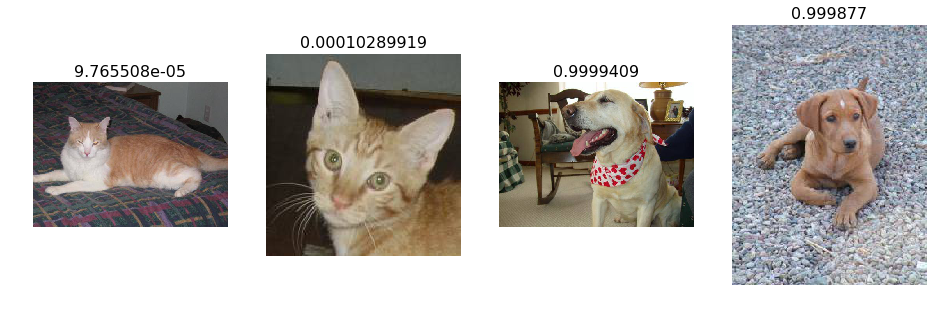

In [81]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


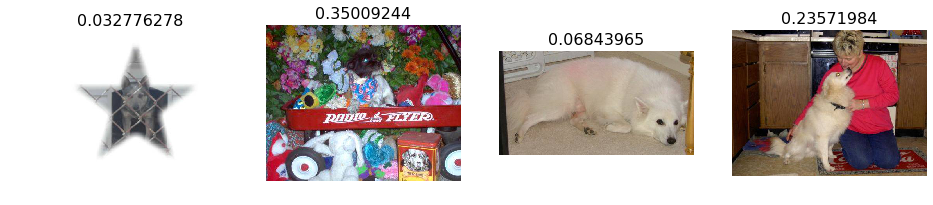

In [82]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [ ]:
# Mult (fold effect -> 1 -> -1)
# Cat(0, True) -> 1
# Cat(0, False) -> -1
# Dog(1, True) -> -1
# Dog(1, False) -> 1

In [86]:
# All correct(True) for cats
# Incorrect preds will be false, but also all the dog preds will be false 
(preds == data.val_y)==True & (data.val_y == 0)

array([ True,  True,  True, ..., False, False, False])

In [88]:
unique1, counts1 = np.unique((preds == data.val_y)==True & (data.val_y == 0), return_counts=True)
dict(zip(unique1, counts1))

{False: 1000, True: 1000}

In [89]:
# All in-correct(False) for cats
(preds == data.val_y)==False & (data.val_y == 0)

array([False, False, False, ..., False, False, False])

In [91]:
unique2, counts2 = np.unique((preds == data.val_y)==False & (data.val_y == 0), return_counts=True)
dict(zip(unique2, counts2))

{False: 1982, True: 18}

In [92]:
# All correct(True) for Dogs
# Incorrect preds will be false, but also all the Cat preds will be false 
(preds == data.val_y)==True & (data.val_y == 1)

array([False, False, False, ...,  True,  True,  True])

In [93]:
unique3, counts3 = np.unique((preds == data.val_y)==True & (data.val_y == 1), return_counts=True)
dict(zip(unique3, counts3))

{False: 1000, True: 1000}

In [94]:
# All in-correct(False) for Dogs
(preds == data.val_y)==False & (data.val_y == 1)

array([False, False, False, ..., False, False, False])

In [95]:
unique4, counts4 = np.unique((preds == data.val_y)==False & (data.val_y == 1), return_counts=True)
dict(zip(unique4, counts4))

{False: 1982, True: 18}

In [103]:
# Quicksort sort from lowest to highest according to the probabilites
# Consider probabilities of idxs
# argsort sorts probabilities and returns the index according to the sort
# access idxs according to the sorted indexes
# A folding trick is applied to obtain correct and incorrect(using 'mult' 1, -1)
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

In [104]:
def most_by_correct(y, is_correct):
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


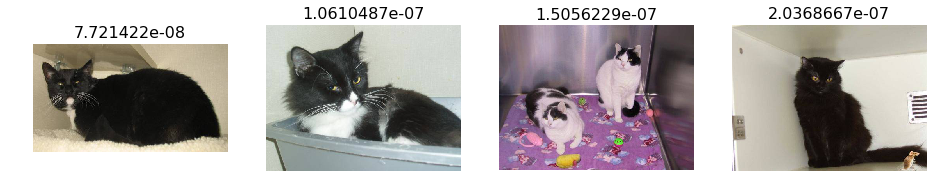

In [105]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


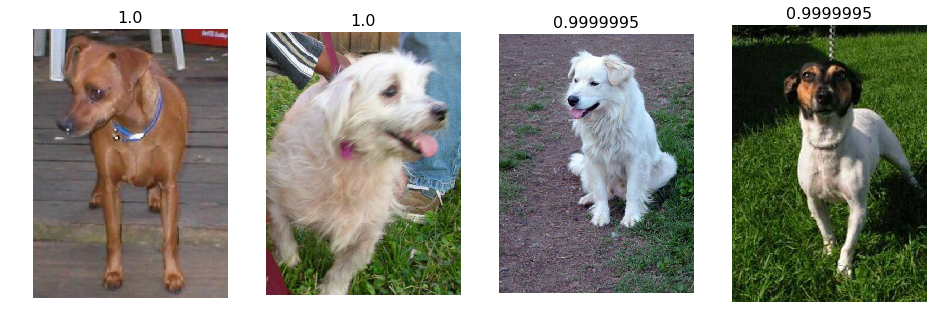

In [106]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most in-correct cats


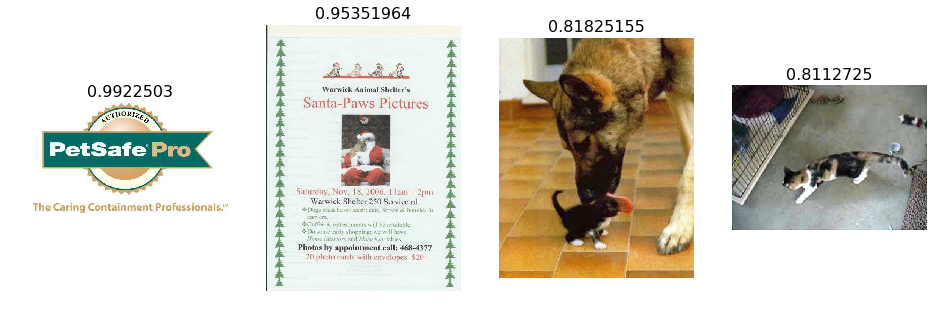

In [107]:
plot_val_with_title(most_by_correct(0, False), "Most in-correct cats")

Most incorrect dogs


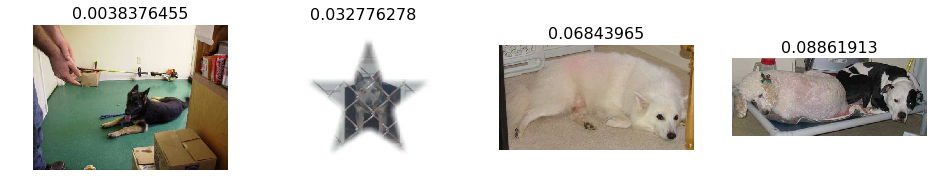

In [108]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

In [110]:
probs[995:1005]

array([0.00004, 0.00046, 0.00018, 0.     , 0.00032, 1.     , 0.99976, 0.99693, 1.     , 0.99895],
      dtype=float32)

In [111]:
probs[995:1005] - 0.5

array([-0.49996, -0.49954, -0.49982, -0.5    , -0.49968,  0.5    ,  0.49976,  0.49693,  0.5    ,  0.49895],
      dtype=float32)

In [112]:
np.abs(probs[995:1005] - 0.5)

array([0.49996, 0.49954, 0.49982, 0.5    , 0.49968, 0.5    , 0.49976, 0.49693, 0.5    , 0.49895],
      dtype=float32)

Most uncertain predictions


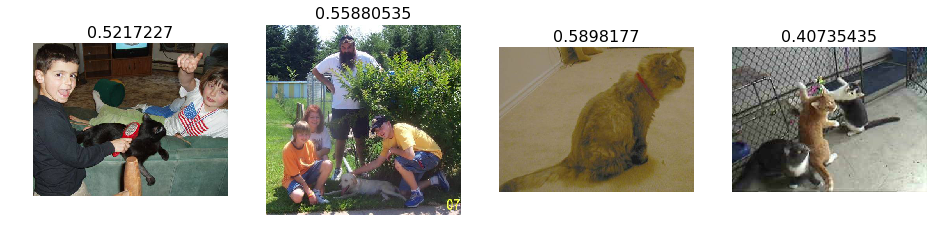

In [113]:
# most uncertain probilities will be far lesser than 0.49
most_uncertain = np.argsort(np.abs(probs - 0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [114]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [115]:
lrf = learn.lr_find()

 82%|████████████████████████████████████████████████████████            | 297/360 [00:03<00:00, 88.39it/s, loss=0.276]


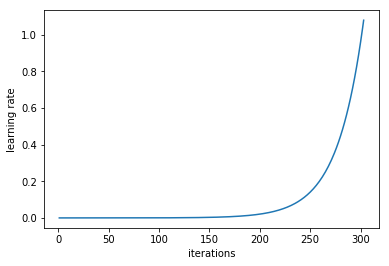

In [116]:
# learn object contains an attribute sched that contains our learning rate 
# scheduler, and has some convenient plotting functionality including this one:
learn.sched.plot_lr()

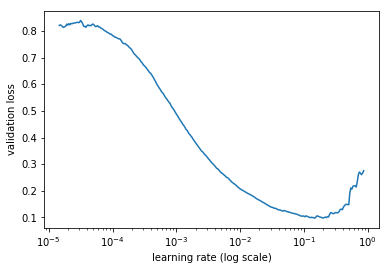

In [117]:
learn.sched.plot()

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use.